<a name="software-requirements"></a>
# Software Requirements

In [1]:
%%bash
python -m pip install --upgrade pip
pip install git+https://github.com/ProfessorGuineapig/climate-learn.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ProfessorGuineapig/climate-learn.git to /tmp/pip-req-build-9wjb4xfy
  Resolved https://github.com/ProfessorGuineapig/climate-learn.git to commit 7750d5b0110260d62e204e299f9f61798ba5d6f8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 87.6 MB/s eta

  Running command git clone --filter=blob:none --quiet https://github.com/ProfessorGuineapig/climate-learn.git /tmp/pip-req-build-9wjb4xfy


In [2]:
#After installing "rich", it is necessary to restart your runtime in order to ensure that all of the necessary components are properly loaded and running. 
!pip install -U rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.3
    Uninstalling rich-13.3.3:
      Successfully uninstalled rich-13.3.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from climate_learn.utils.data import load_dataset, view
from climate_learn.data import download1

dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.20/2m_temperature")
view(dataset)

<xarray.Dataset>
Dimensions:    (longitude: 16, latitude: 16, time: 291542)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.8 -80.6 -80.4 ... -78.4 -78.2 -78.0
  * latitude   (latitude) float32 45.0 44.8 44.6 44.4 ... 42.6 42.4 42.2 42.0
  * time       (time) datetime64[ns] 1990-01-01 ... 2023-04-05T13:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 16, 16), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-10 08:34:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

<a name="temporal-forecasting"></a>
# Temporal Forecasting

## Data Preparation

Check out the [Data Processing Notebook](https://github.com/aditya-grover/climate-learn/tree/main/docs/notebooks/Data_Processing) for more info on this part.

Creating train dataset



100%|██████████| 1/1 [00:00<00:00, 26.13it/s]


Creating val dataset



100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


Creating test dataset



100%|██████████| 3/3 [00:00<00:00, 37.66it/s]


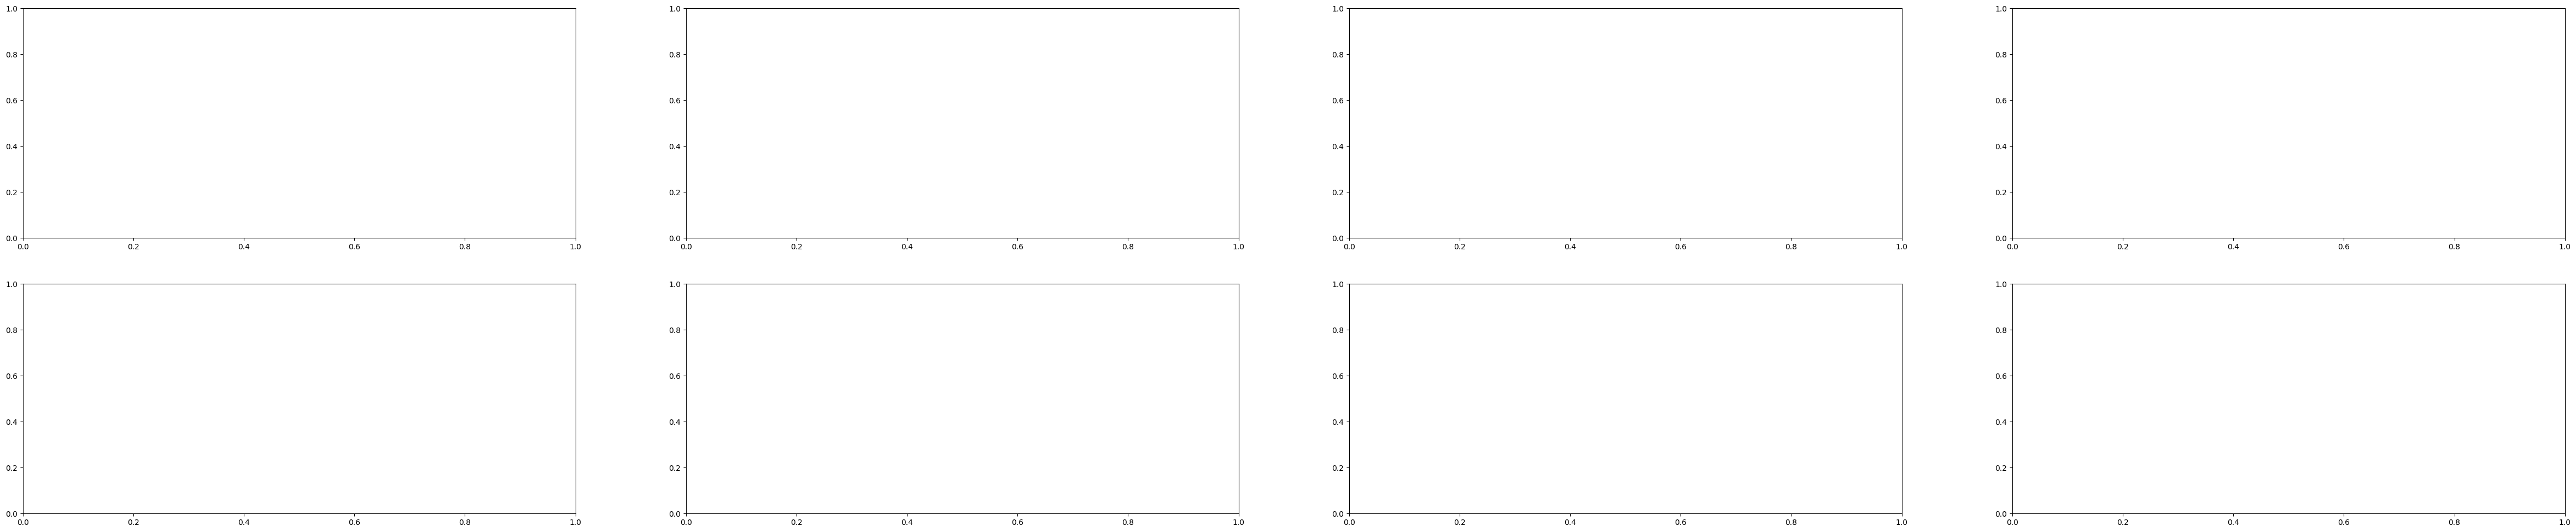

In [35]:
from climate_learn.utils.data import load_dataset, view
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import ForecastingArgs
from climate_learn.data import download1, DataModuleArgs, DataModule

# Download data from weatherbench (~2-3 minutes)
#download1(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "5.625")

#dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/era5/0.5/2m_temperature")
#view(dataset)

data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.20/",
    variables = ["2m_temperature"],
    years = range(2018, 2022),
)

forecasting_args = ForecastingArgs(
    dataset_args = data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    pred_range = 1*24,
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = forecasting_args,
    #train_start_year = 1975,
    train_start_year = 2018,
    val_start_year = 2019,
    test_start_year = 2020,
    deploy_start_year = None, #Add this line, which can be "None"
    end_year = 2022,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 128,
    num_workers = 1
)

In [ ]:
data_module_args.test_start_year

2017

## Model initialization 

In [43]:
from climate_learn.models import load_model

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4
}

# Only for Vit
"""model_kwargs = {
    "img_size":[32, 64],
    "patch_size":4,
    "drop_path":0.1,
    "drop_rate":0.1,
    "learn_pos_emb": False,
    "in_vars":[
        "2m_temperature",
        ],
    "out_vars":["2m_temperature"],
    "embed_dim":256,
    "depth":6,
    "decoder_depth":2,
    "num_heads":4,
    "mlp_ratio":1,
}"""

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

#model_module_forecasting = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
#model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
model_module_forecasting = load_model(name = "unet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [19]:
from climate_learn.models import set_climatology
set_climatology(model_module_forecasting, data_module)

## Training

In [44]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    #accelerator = "cpu",
    precision = 16,
    max_epochs = 4,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.9/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(


In [45]:
model_module_forecasting.lat

In [46]:
import os
import torch
from torchvision.transforms import Normalize

#Continued by following the previous training session
save_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#Continued by following the previous training session
save_path = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/trained_model__Toronto_04_12_0_20_unet(1d&batch_size128&0.2).pth"

# Load the state_dict and denormalization layer information
checkpoint = torch.load(save_path)
model_state_dict = checkpoint['model_state_dict']
denormalization_mean = checkpoint['denormalization_mean']
denormalization_std = checkpoint['denormalization_std']
pred_range = checkpoint['pred_range']
lat = checkpoint['lat']
test_clim = checkpoint['test_clim']
train_clim = checkpoint['train_clim']

# Update the model_module_forecasting with the loaded state_dict
model_module_forecasting.load_state_dict(model_state_dict)
model_module_forecasting.pred_range = pred_range
model_module_forecasting.lat = lat
model_module_forecasting.test_clim = test_clim
model_module_forecasting.train_clim = train_clim

# Recreate the denormalization layer using the saved mean and standard deviation
model_module_forecasting.denormalization = Normalize(mean=denormalization_mean, std=denormalization_std)

In [47]:
model_module_forecasting

ForecastLitModule(
  (net): Unet(
    (activation): LeakyReLU(negative_slope=0.3)
    (image_proj): PeriodicConv2D(
      (padding): PeriodicPadding2D()
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    )
    (down): ModuleList(
      (0-3): 4 x DownBlock(
        (res): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): PeriodicConv2D(
            (padding): PeriodicPadding2D()
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
          (conv2): PeriodicConv2D(
            (padding): PeriodicPadding2D()
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
          (shortcut): Identity()
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (attn): Identity()
      

In [22]:
from climate_learn.models import fit_lin_reg_baseline
fit_lin_reg_baseline(model_module_forecasting, data_module, reg_hparam=0.0)

## Evaluation 


In [48]:
trainer.test(model_module_forecasting, data_module)

Creating train dataset



100%|██████████| 1/1 [00:00<00:00, 33.93it/s]


Creating val dataset



100%|██████████| 1/1 [00:00<00:00, 48.06it/s]


Creating test dataset



100%|██████████| 3/3 [00:00<00:00, 53.12it/s]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                        test/acc                        │                   0.6581142544746399                   │
│            test/acc_2m_temperature_1.0_days            │                   0.6581142544746399                   │
│                      test/w_rmse                       │                   2.6785058975219727                   │
│          test/w_rmse_2m_temperature_1.0_days           │                   2.6785058975219727                   │
│            test_climatology_baseline/w_rmse            │                   8.735182762145996                    │
│ test_climatology_baseline/w_rmse_2m_temperature_1.0_d… │                   8.735182762145996                    │
│            test_persistence_baseline/w_rmse            │                   3.306151866912842                    │
│ test_persistence_baseline/w_rmse_2m_temperature_1.0_d… │                   3.306151866912842                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

This visualization displays the results of a random test for the Unet model. It shows the weather forecast for the temperature of the selected region (area = [42.0, -81.0, 45.0, -78.0]) in a short time period (1 days). The initial condition is the temperature of the date we selected to test, the ground truth is the actual temperature after 1 days, and the prediction is the outcome of the trained model. 


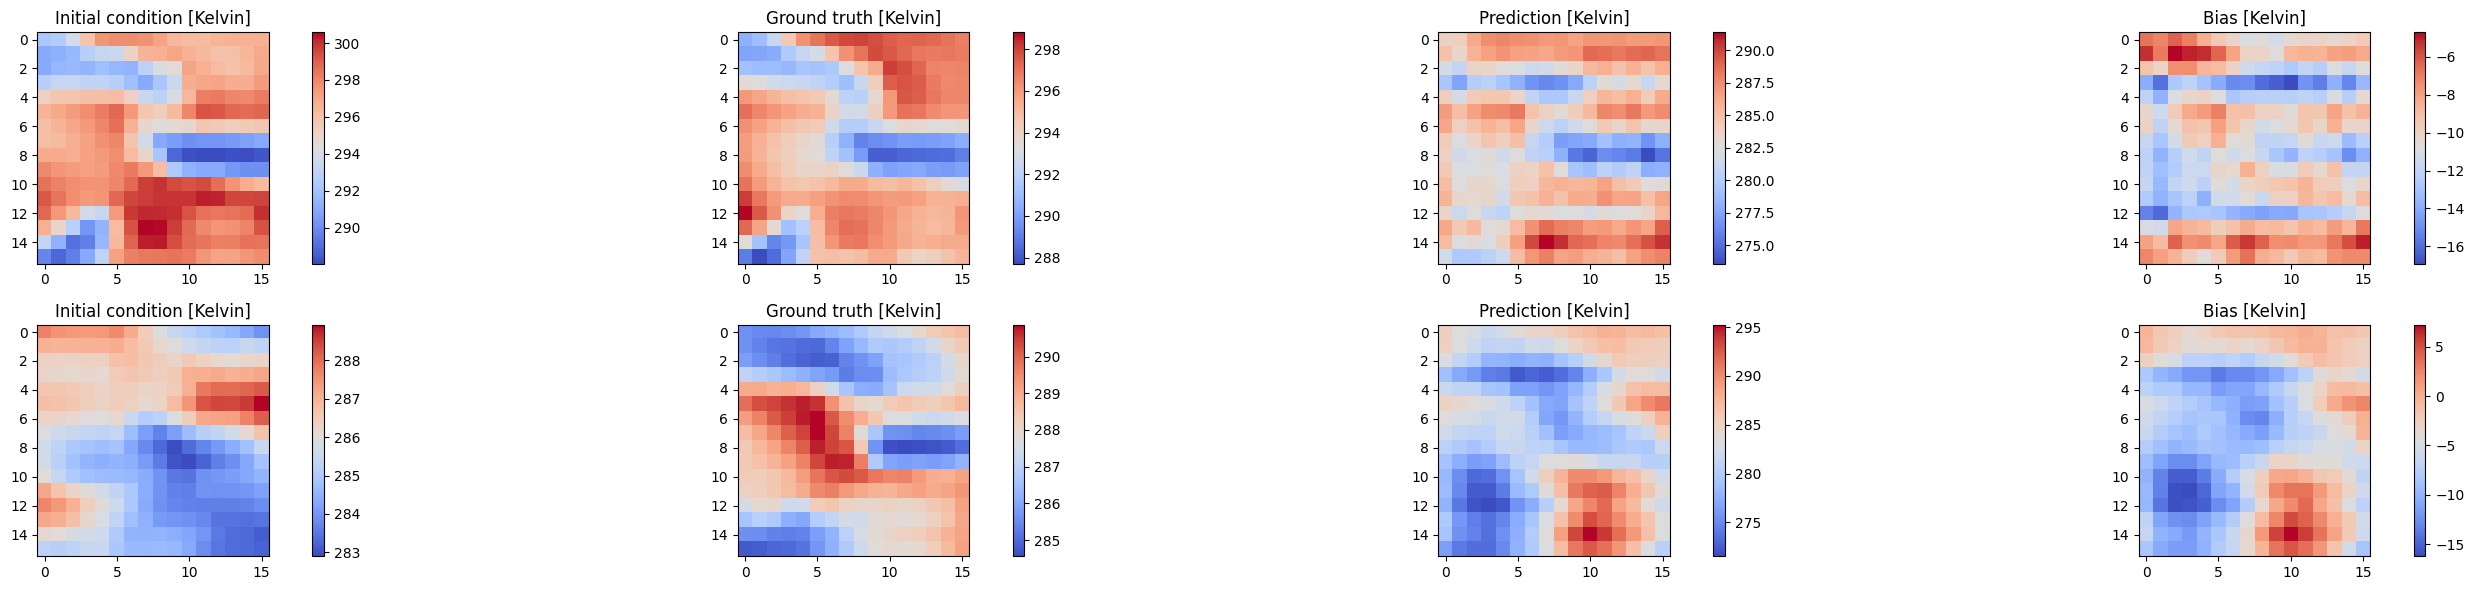

In [49]:
from climate_learn.utils import visualize

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module_forecasting, data_module, samples = 2)

# Deployment


In [31]:
pip install gradio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 

In [36]:
#The modified visulization functions for deployment.
import matplotlib.pyplot as plt
from climate_learn.data.tasks import Downscaling, Forecasting


def interpolate_input(x: torch.Tensor, y: torch.Tensor):
    # interpolate input to match output size
    out_h, out_w = y.shape[-2], y.shape[-1]
    x = torch.nn.functional.interpolate(x, (out_h, out_w), mode="bilinear")
    return x

def visualize_gr(model_module, data_module, split="test", samples=2, save_dir=None, output=None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    task_dataset = eval(f"data_module.{split}_dataset")

    if type(samples) == int:
        idxs = random.sample(range(0, len(task_dataset)), samples)
    elif type(samples) == list:
        idxs = [
            np.searchsorted(
                task_dataset.time, np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H"))
            )
            for dt in samples
        ]
    else:
        raise Exception(
            "Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]"
        )

    fig, axes = plt.subplots(len(idxs), 4, figsize=(60, 6 * len(idxs)), squeeze=False)

    for index, idx in enumerate(idxs):
        x, y, _, _ = task_dataset[idx]
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        x = interpolate_input(x, y)
        pred = model_module.forward(x.unsqueeze(0))

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        init_condition = np.flip(init_condition.detach().cpu().squeeze().numpy(), 0)
        pred = inv_normalize(pred)
        pred = np.flip(pred.detach().cpu().squeeze().numpy(), 0)
        gt = np.flip(gt.detach().cpu().squeeze().numpy(), 0)
        bias = pred - gt

        for i, np_array in enumerate([init_condition, gt, pred, bias]):
            ax = axes[index][i]
            im = ax.imshow(np_array)
            im.set_cmap(cmap=plt.cm.coolwarm)
            fig.colorbar(im, ax=ax)

        if isinstance(task_dataset, Forecasting):
            axes[index][0].set_title("Initial condition [Kelvin]")
            axes[index][1].set_title("Ground truth [Kelvin]")
            axes[index][2].set_title("Prediction [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        elif isinstance(task_dataset, Downscaling):
            axes[index][0].set_title("Low resolution data [Kelvin]")
            axes[index][1].set_title("High resolution data [Kelvin]")
            axes[index][2].set_title("Downscaled [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        else:
            raise NotImplementedError

    fig.tight_layout()

    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "visualize.png"), dpi=300)
    elif output is not None:
        plt.savefig(output, format='png')
    else:
        plt.show()

In [ ]:
"""data_module.test_start_year = data_module_args.test_start_year
data_module.end_year = data_module_args.end_year"""

In [37]:
import gradio as gr
import numpy as np
from PIL import Image
from climate_learn.utils import visualize
import matplotlib.pyplot as plt
from climate_learn.data.tasks import Downscaling, Forecasting
from io import BytesIO
from datetime import datetime
import random
import numpy as np

data_module.test_start_year = data_module_args.test_start_year
data_module.end_year = data_module_args.end_year

def get_random_dates(data_module, n=2):
    test_start_year = data_module.test_start_year
    end_year = data_module.end_year

    random_dates = []
    for _ in range(n):
        random_year = random.randint(test_start_year, end_year - 1)
        random_month = random.randint(1, 12)
        random_day = random.randint(1, 28)
        random_hour = random.randint(0, 23)
        random_date = datetime(random_year, random_month, random_day, random_hour)
        random_dates.append(random_date.strftime("%Y-%m-%d:%H"))

    return ",".join(random_dates)

def visualize_gradio(dates: str):
    dates_list = dates.split(',')
    buffer = BytesIO()
    visualize_gr(model_module_forecasting, data_module, samples=dates_list, output=buffer)
    buffer.seek(0)
    img_binary = buffer.getvalue()
    img = Image.open(BytesIO(img_binary))
    return img

In [38]:
random_dates = get_random_dates(data_module)


layout = {
    "width": "100%",
    "height": "800px",
    "fullscreen": False,
    "title": "Climate Model Visualization",
    "description": "Randomly pick initial conditions in the test set and visualize the model's output.",
    "inputs": [
        ["Dates (YYYY-MM-DD:HH)", "text"],
    ],
    "outputs": [
        ["Output Image", "numpy_image"],
    ],
    "style": "vertical",
}

demo = gr.Interface(
    fn=visualize_gradio,
    inputs=gr.inputs.Textbox(lines=2, label="Dates (YYYY-MM-DD:HH)", default=random_dates),
    outputs=gr.outputs.Image('numpy'),
    layout=layout,
    title="Climate Model Visualization",
    description="Randomly pick initial conditions in the test set and visualize the model's output.",
    split="none",
)

demo.launch()

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:43: UserWarning: You ha

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Testing with dates: 2021-01-09:16,2021-07-26:09


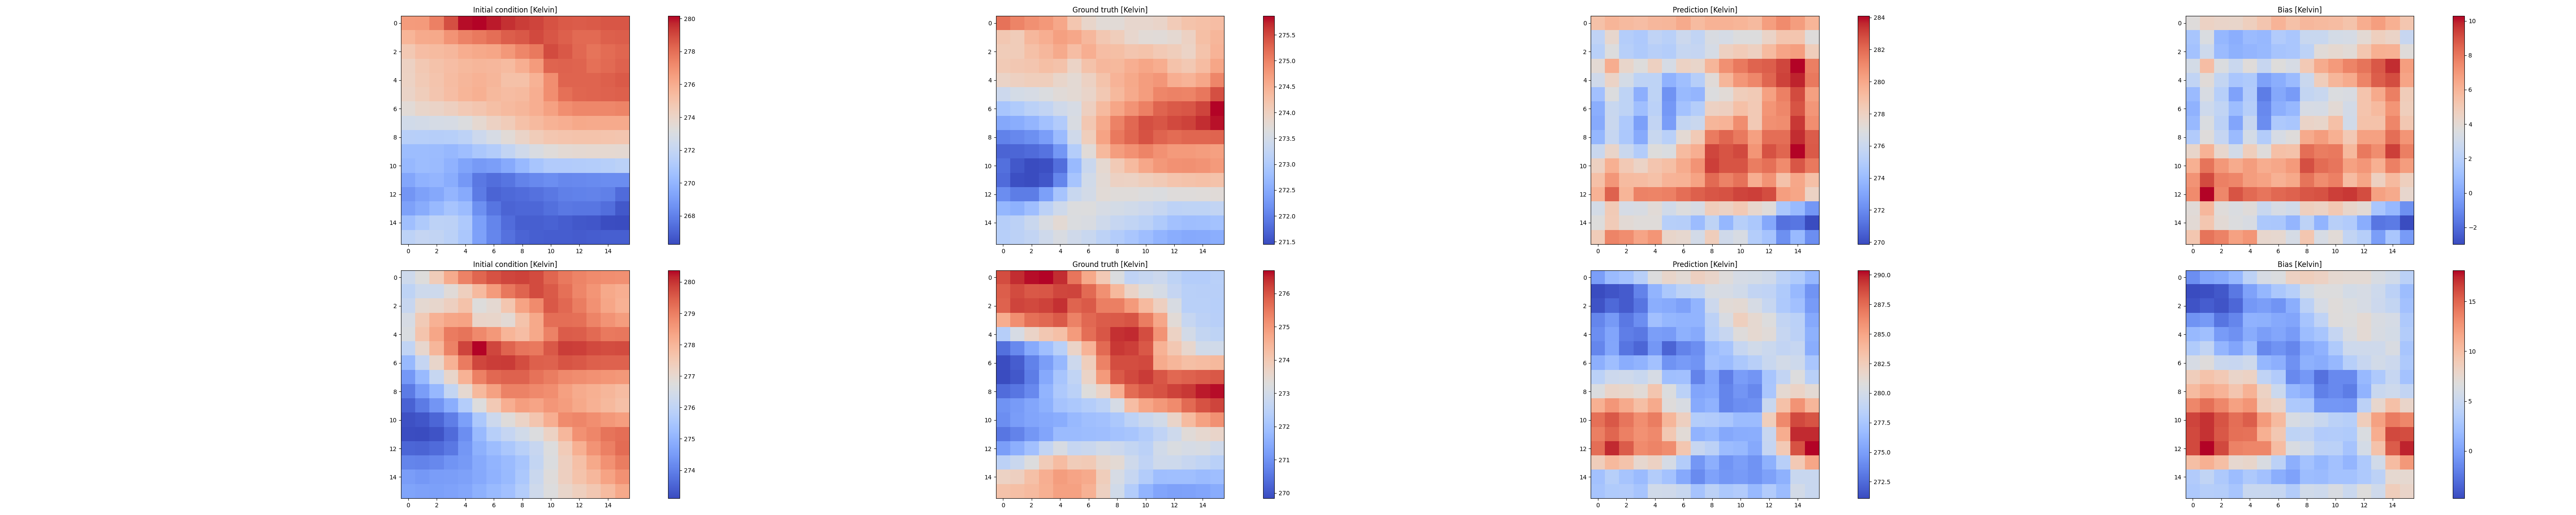

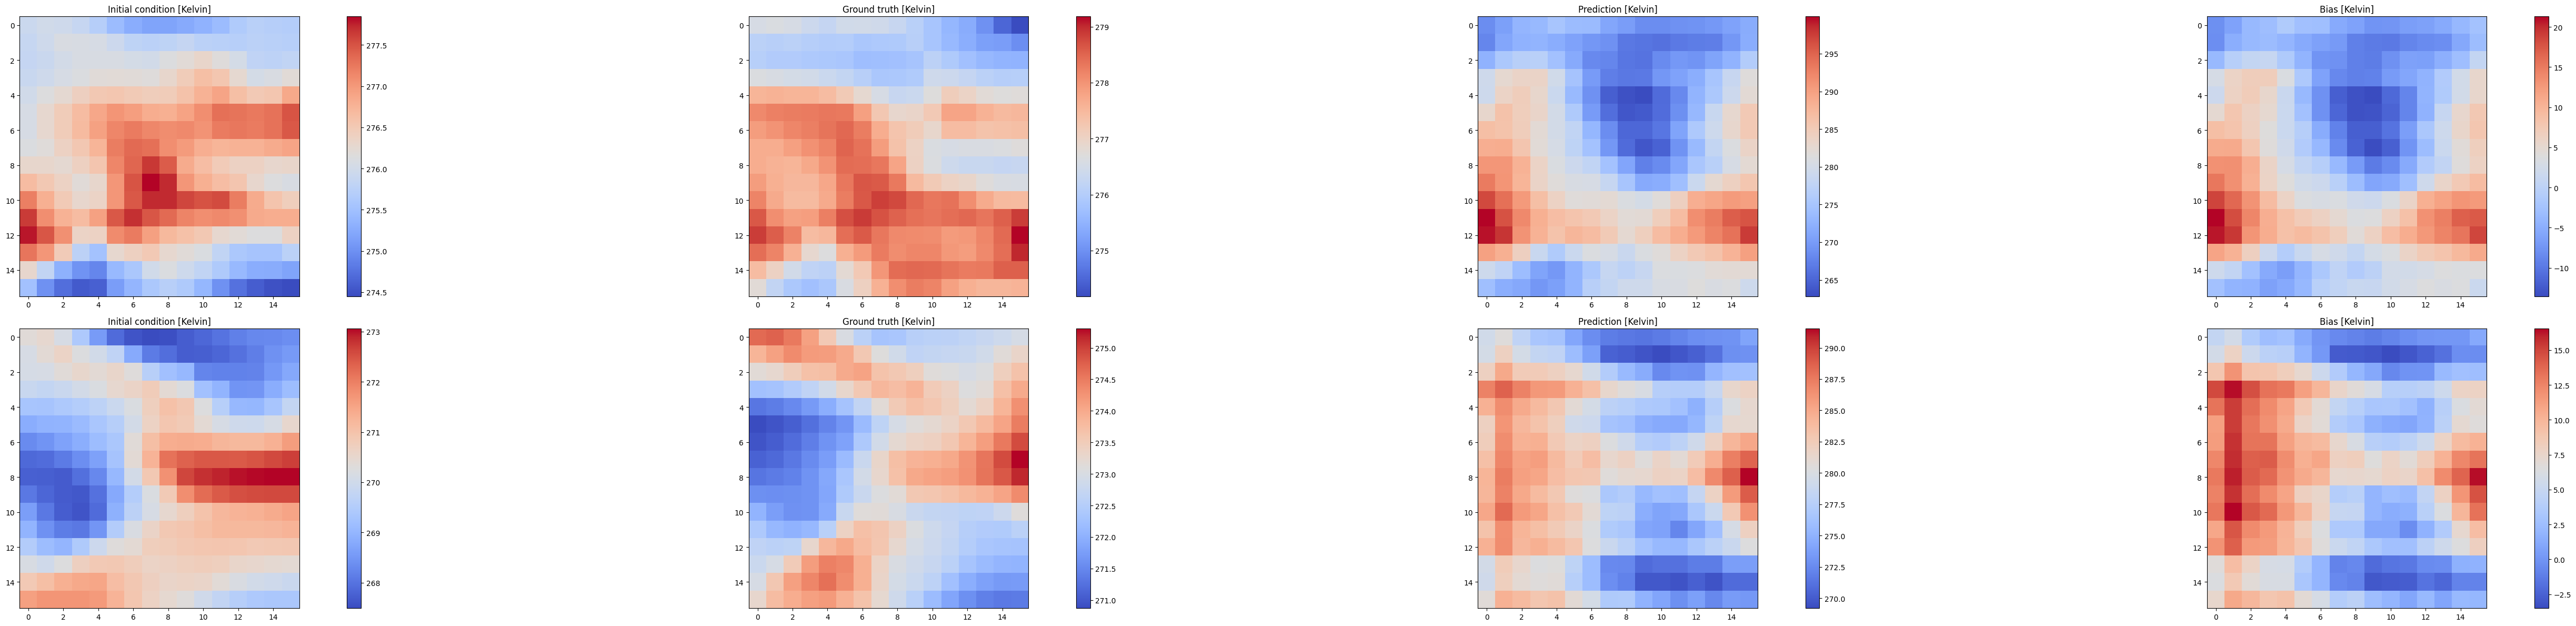

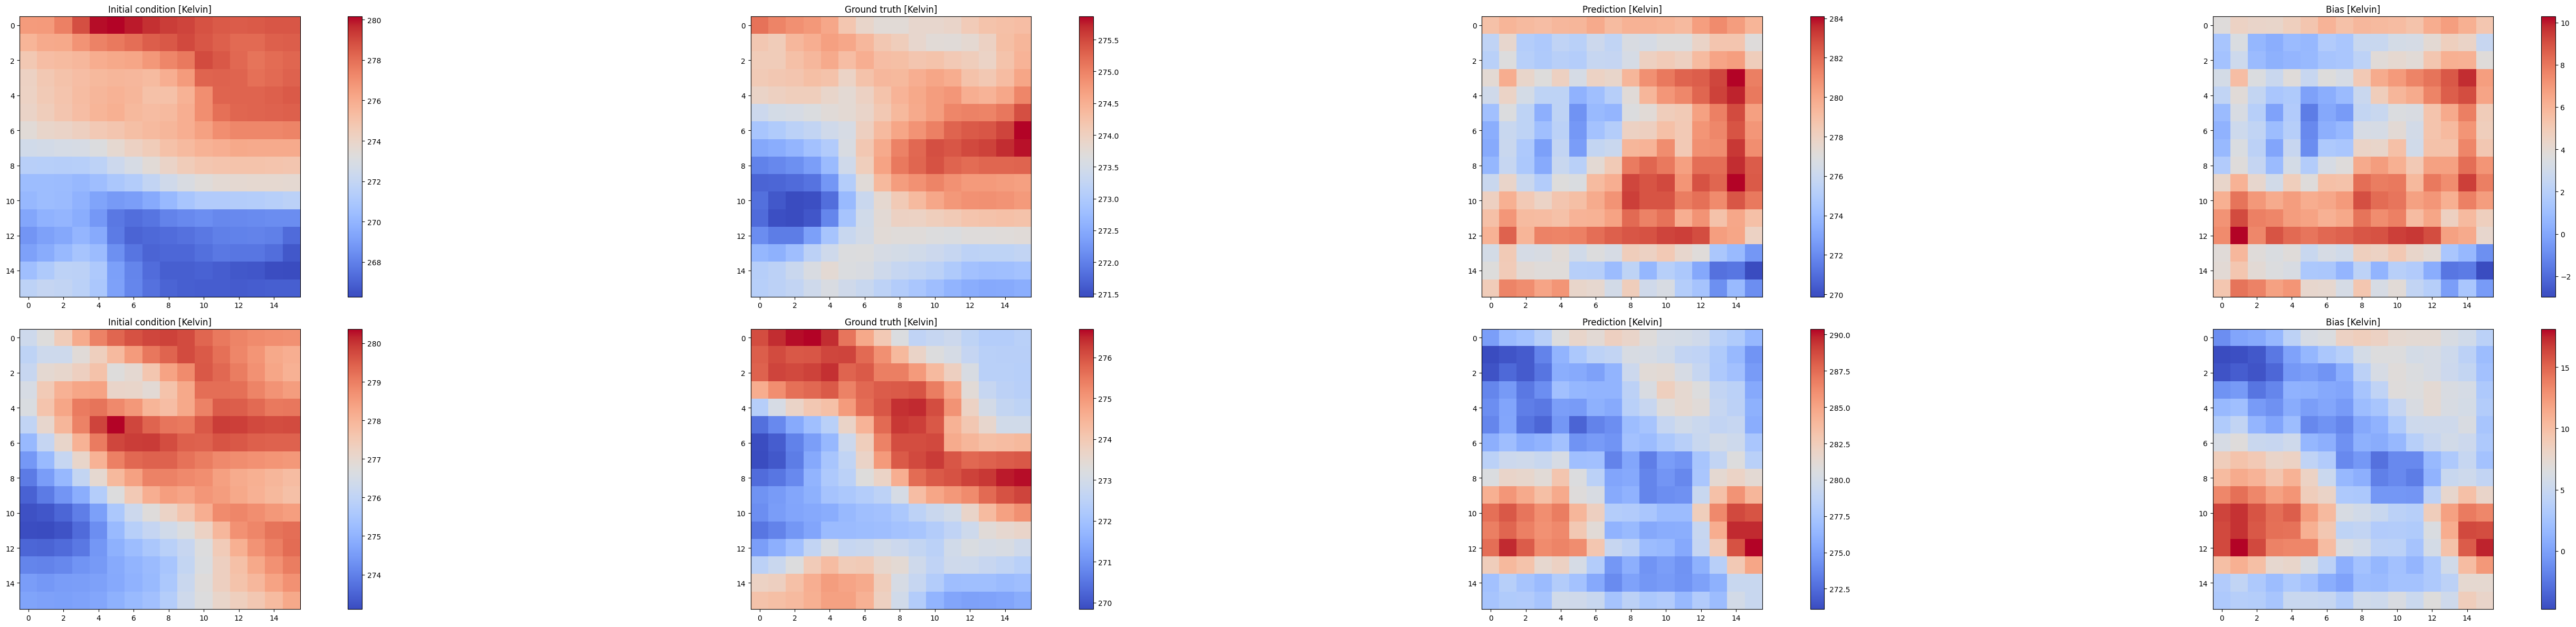

In [50]:
#Test functions for deployment
from IPython.display import display

test_dates = get_random_dates(data_module)
print("Testing with dates:", test_dates)
test_image = visualize_gradio(test_dates)
display(test_image)

<a name="spatial-downscaling"></a>
# Spatial Downscaling

## Data Preparation

In [ ]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import DownscalingArgs
from climate_learn.data import download, DataModuleArgs, DataModule

# Download data from weatherbench (~4-6 minutes)
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "2.8125")

lowres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

highres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/2.8125",
    variables = ["2m_temperature"],
    years = range(1979, 2015),
)

downscaling_args = DownscalingArgs(
    dataset_args = data_args,
    highres_dataset_args = highres_data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = downscaling_args,
    train_start_year = 1979,
    val_start_year = 2015,
    test_start_year = 2017,
    end_year = 2018,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:00<00:00, 30.77it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 26.84it/s]


Creating test dataset


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


## Model initialization

In [ ]:
from climate_learn.models import load_model
from torch.optim import AdamW

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": AdamW,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [ ]:
# latitude long info, 
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

## Training

In [ ]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
trainer.fit(model_module, data_module)

/usr/local/lib/python3.8/dist-packages/lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

## Evaluation

In [ ]:
trainer.test(model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias_2m_temperature │      -0.6033839583396912      │
│ test/pearsonr_2m_temperature  │      0.9910030555527313       │
│   test/rmse_2m_temperature    │       2.859203577041626       │
└───────────────────────────────┴───────────────────────────────┘